In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import argparse
import os 
import glob

In [2]:
outputdir= "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_plots/simScore_scan"
os.makedirs(outputdir,exist_ok=True)
input_version = 14

inputdir = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/"
ens = [ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
etas = [0,1.479,1.75,3]
dnn_thres =  np.linspace(0.3 ,1, 30)[:-1]
simscore_thres = np.linspace(0.01, 0.1, 20)[:-1]
ninputfiles = 20


In [3]:
datas_ele = []

i = 0

for f in glob.glob(inputdir+ "electrons/numpy_v{}/testing/clusters_data_*.pkl".format(input_version)):
    i+=1
    if i >ninputfiles: break
    d = pickle.load(open(f, "rb"))
    datas_ele.append( d[(d.is_calo_matched == True)] )

data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

i = 0
datas_gamma = []
for f in glob.glob(inputdir+ "gammas/numpy_v{}/testing/clusters_data_*.pkl".format(input_version)):
    i+=1
    if i >ninputfiles: break
    d = pickle.load(open(f, "rb"))
    datas_gamma.append(d[ (d.is_calo_matched == True)])
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data_val = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data_val = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)

print(f"N samples ele {data_ele.shape}")
print(f"N samples gamma {data_gamma.shape}")


data = pd.concat([data_ele, data_gamma])



N events ele:  2852006
N events gamma:  2298521
N samples ele (2852006, 41)
N samples gamma (2298521, 41)


In [4]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "semiwidth_left": ratio_mean - ratio_left,
             "semiwidth_right": ratio_right - ratio_mean,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (abs(ratio_right-ratio_mean) + abs(ratio_left-ratio_mean))/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std()
        })



In [5]:
results = []
for simscore_thre in simscore_thres:
    g = data_val[(data_val.cl_simscore > simscore_thre)| (data_val.is_seed==True)].groupby("window_index", sort=False).agg(
                            { "en_cluster_calib": 'sum' ,
                              "en_true": "first", 
                              "et_seed_calib": "first",
                              "seed_eta": "first"
                            })
    
    g["EoEtrue"] = g["en_cluster_calib"] / g["en_true"]
    g["en_bin"] = pd.cut(g["et_seed_calib"], ens, labels=list(range(len(ens)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))
    scanres = g.groupby(["en_bin", "eta_bin"]).apply(bin_analysis)
    scanres["simscore_thre"] = simscore_thre
    results.append(scanres)
    
result_true = pd.concat(results)
# index by en_bin and DNN threshold
result_true.reset_index(inplace=True)

In [6]:
result_true[(result_true.en_bin==0)&(result_true.eta_bin==0)]

,en_bin,eta_bin,quantile_down,quantile_up,semiwidth_left,semiwidth_right,EoEtrue_68scale,EoEtrue_68width,EoEtrue_scale,EoEtrue_rms,simscore_thre
0,0,0,0.794456,0.986292,0.119237,0.072599,0.913694,0.095918,0.943259,9.724214,0.010000
30,0,0,0.792492,0.985622,0.119828,0.073302,0.912320,0.096565,0.941764,9.724226,0.014737
60,0,0,0.789400,0.985158,0.121489,0.074269,0.910889,0.097879,0.940318,9.724245,0.019474
90,0,0,0.785140,0.984526,0.124111,0.075275,0.909251,0.099693,0.938691,9.724265,0.024211
120,0,0,0.781737,0.984108,0.125771,0.076600,0.907508,0.101185,0.936914,9.724289,0.028947
150,0,0,0.778501,0.983640,0.127205,0.077935,0.905706,0.102570,0.935041,9.724314,0.033684
180,0,0,0.773320,0.983286,0.130636,0.079329,0.903956,0.104983,0.933191,9.724341,0.038421
210,0,0,0.769125,0.982889,0.133062,0.080702,0.902188,0.106882,0.931251,9.724370,0.043158
240,0,0,0.764321,0.982389,0.136072,0.081995,0.900394,0.109034,0.929297,9.724399,0.047895
270,0,0,0.759401,0.981899,0.138954,0.083543,0.898356,0.111249,0.927069,9.724428,0.052632


In [7]:
## Analyzine only mustache
g = data_val[ data_val.in_mustache==True ].groupby("window_index", sort=False).agg(
                    { "en_cluster_calib": 'sum' ,
                              "en_true": "first", 
                              "et_seed_calib": "first",
                              "seed_eta": "first"
                            })
#print(g)
g["EoEtrue"] = g["en_cluster_calib"] / g["en_true"]
g["en_bin"] = pd.cut(g["et_seed_calib"], ens, labels=list(range(len(ens)-1)))
g["eta_bin"] = pd.cut(g["seed_eta"], etas, labels=list(range(len(etas)-1)))
result_must = g.groupby(["en_bin", "eta_bin"]).apply(bin_analysis)
result_must.reset_index(inplace=True)


In [8]:
result_must.head()

,en_bin,eta_bin,quantile_down,quantile_up,semiwidth_left,semiwidth_right,EoEtrue_68scale,EoEtrue_68width,EoEtrue_scale,EoEtrue_rms
0,0,0,0.857908,1.048762,0.098258,0.092596,0.956166,0.095427,0.939621,0.197037
1,0,1,0.554009,1.004326,0.273582,0.176735,0.827592,0.225158,0.821554,1.165229
2,0,2,0.768097,1.084161,0.163430,0.152633,0.931527,0.158032,3.836278,209.366599
3,1,0,0.930689,1.020246,0.044576,0.044981,0.975265,0.044779,0.968476,0.122862
4,1,1,0.859061,1.020709,0.090829,0.070818,0.949891,0.080824,0.932418,0.161955


/usr/local/bin/start_ipykernel.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


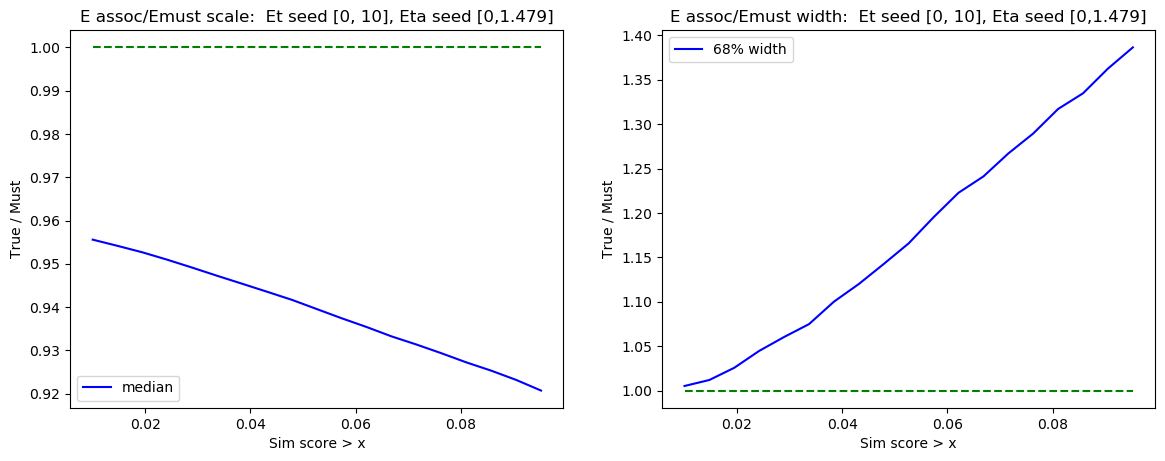

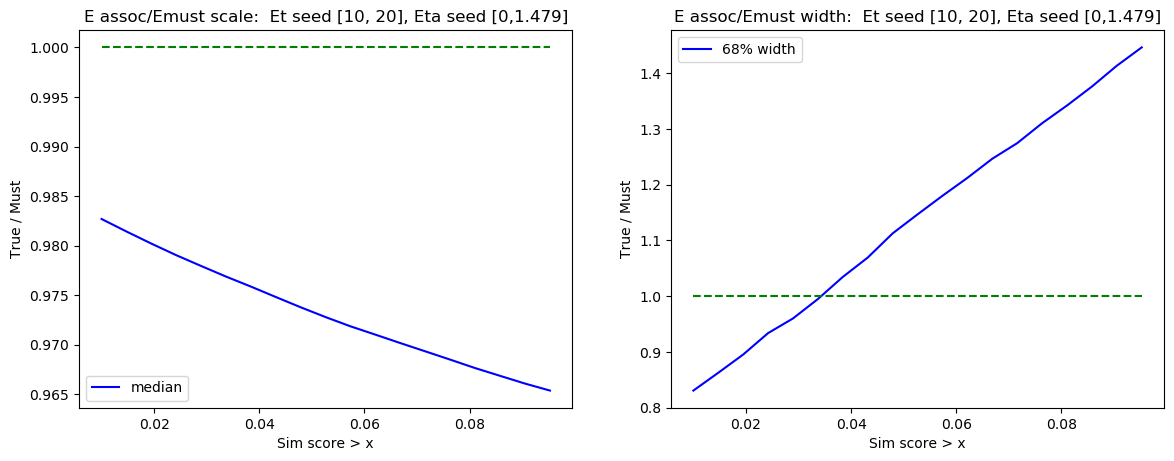

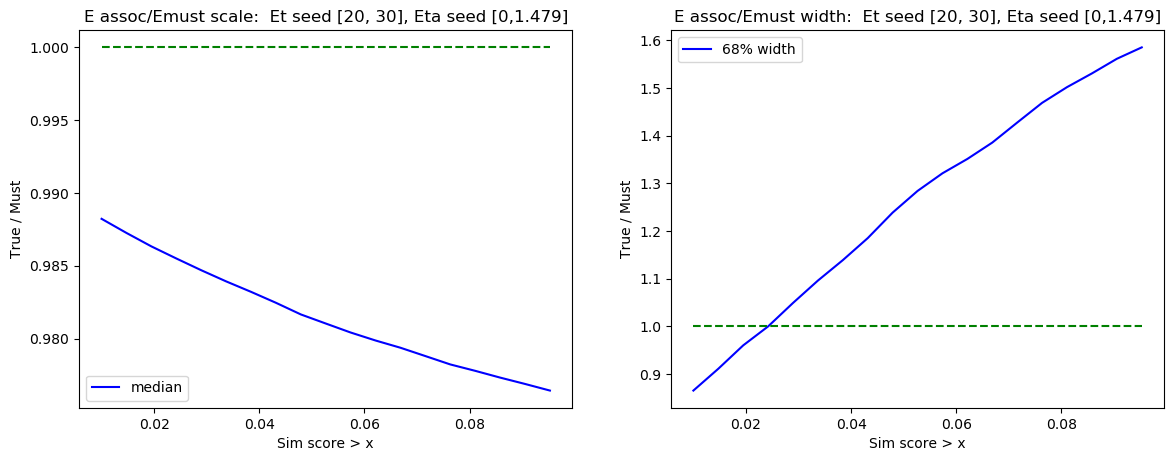

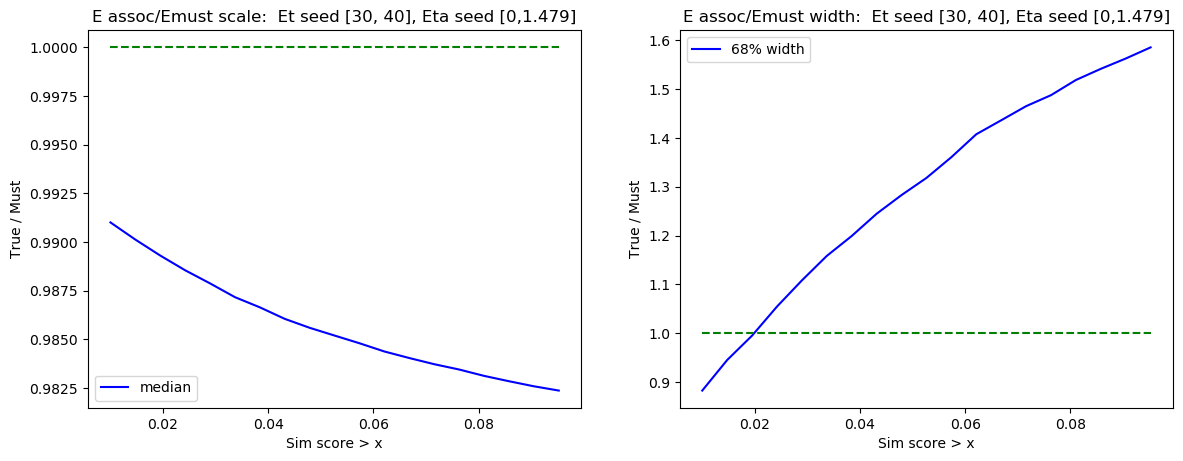

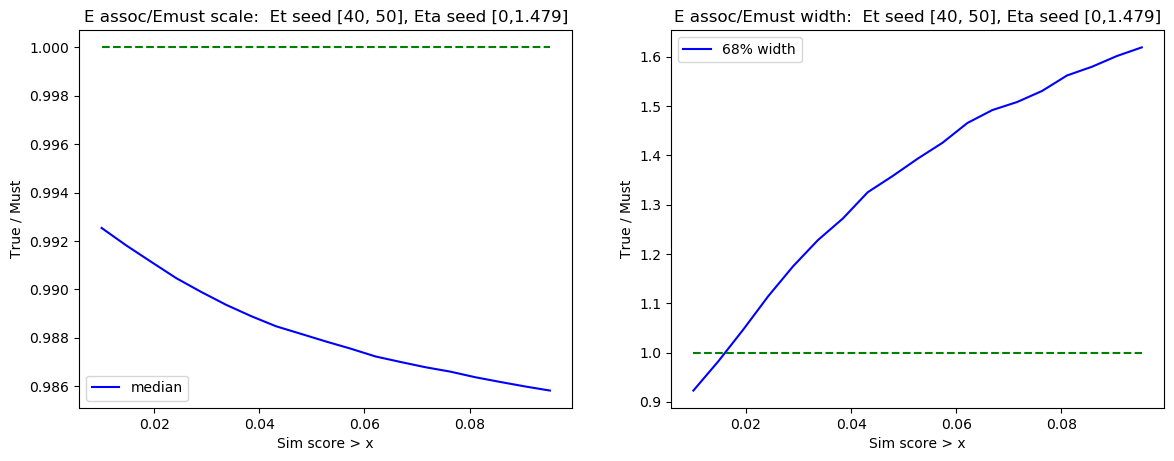

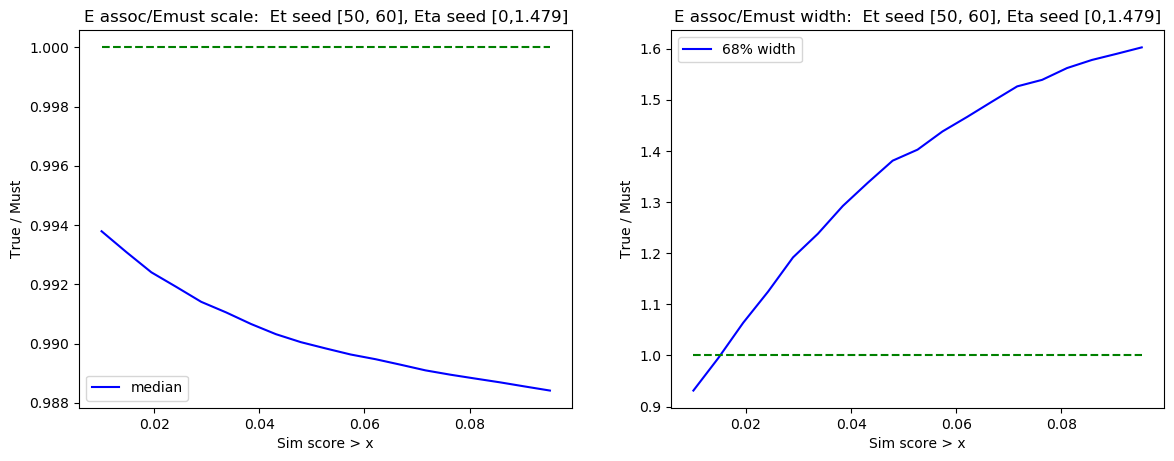

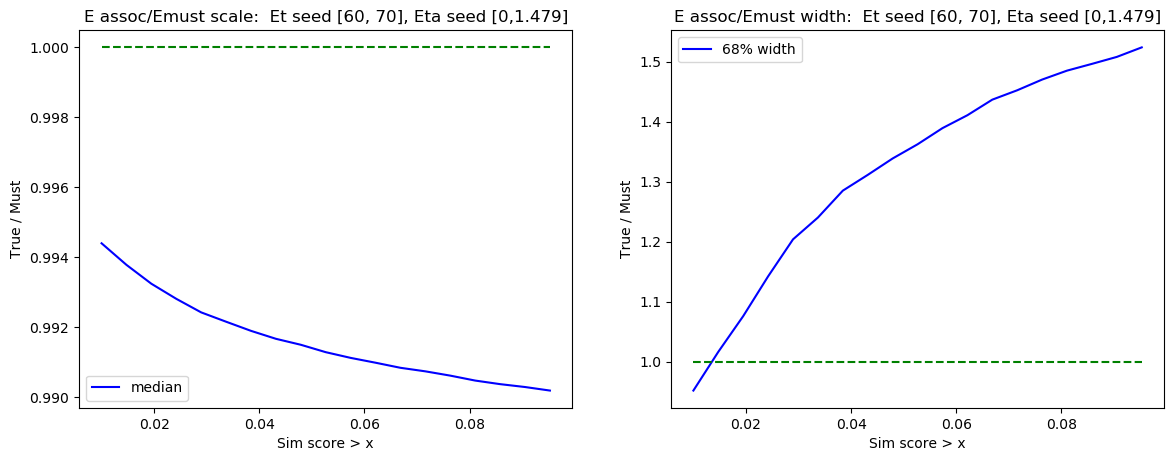

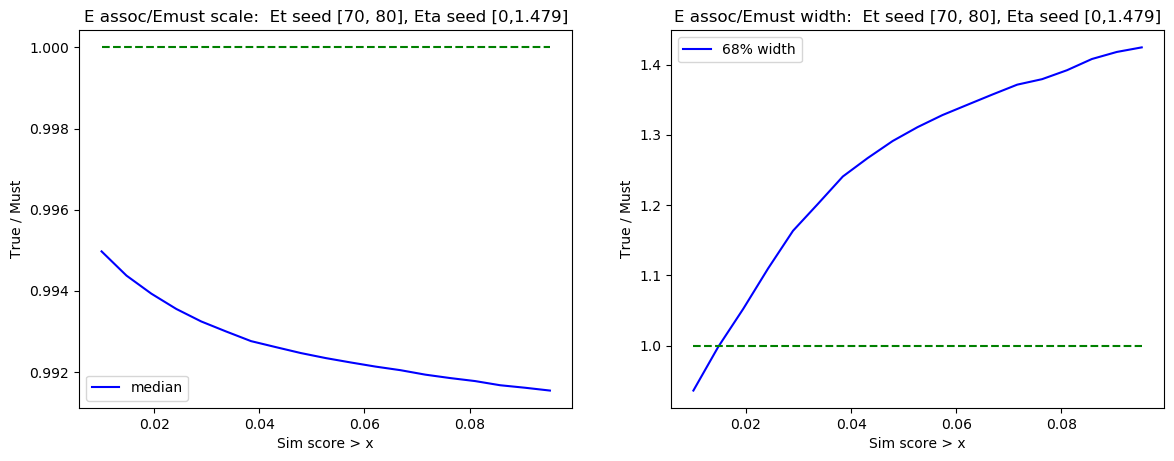

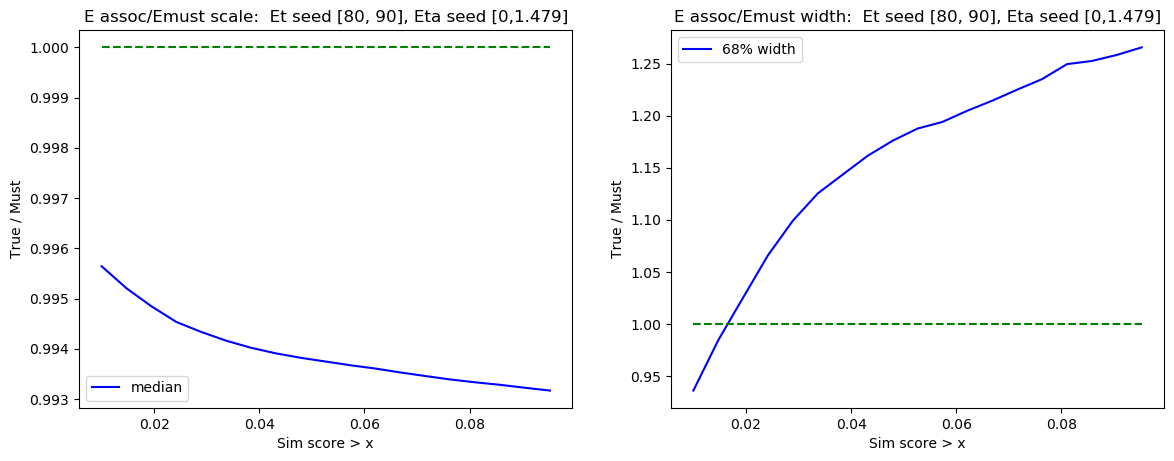

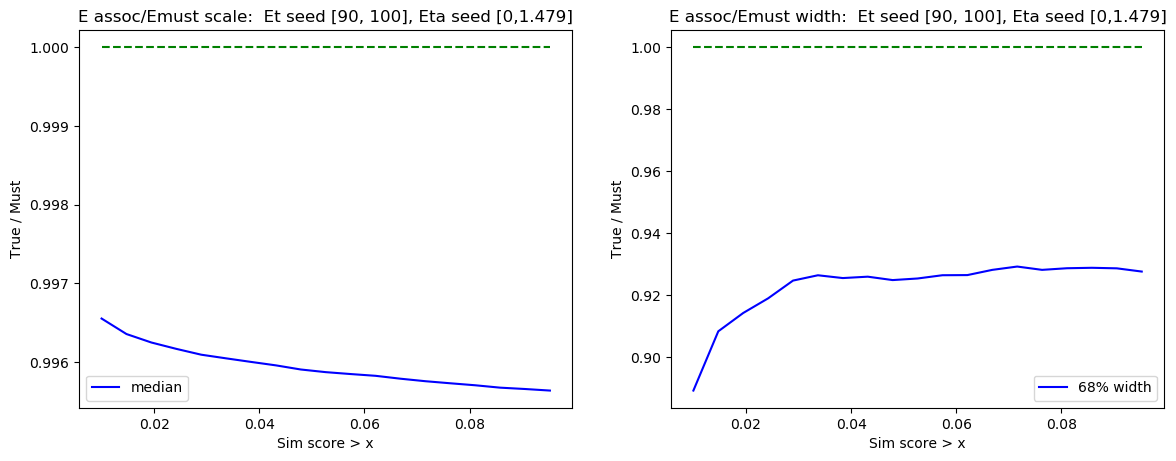

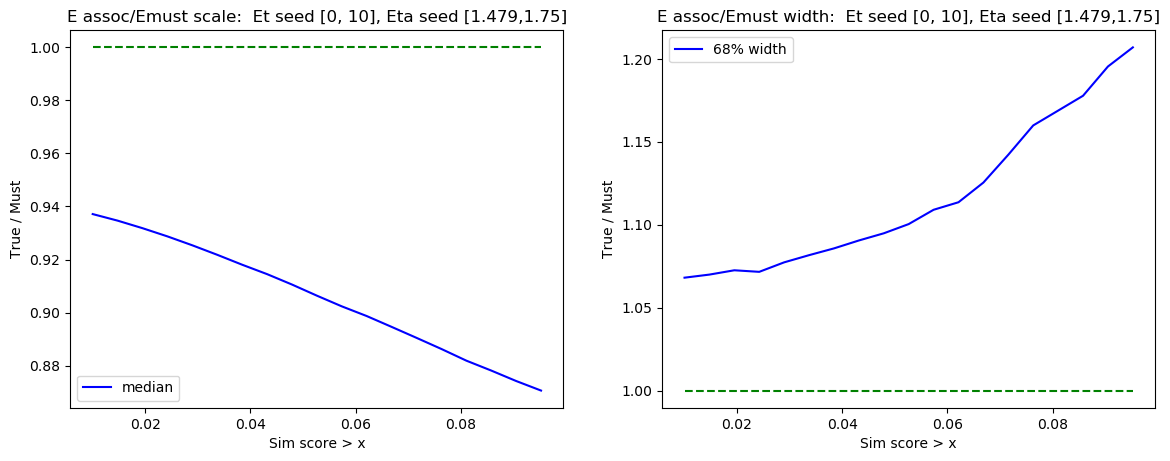

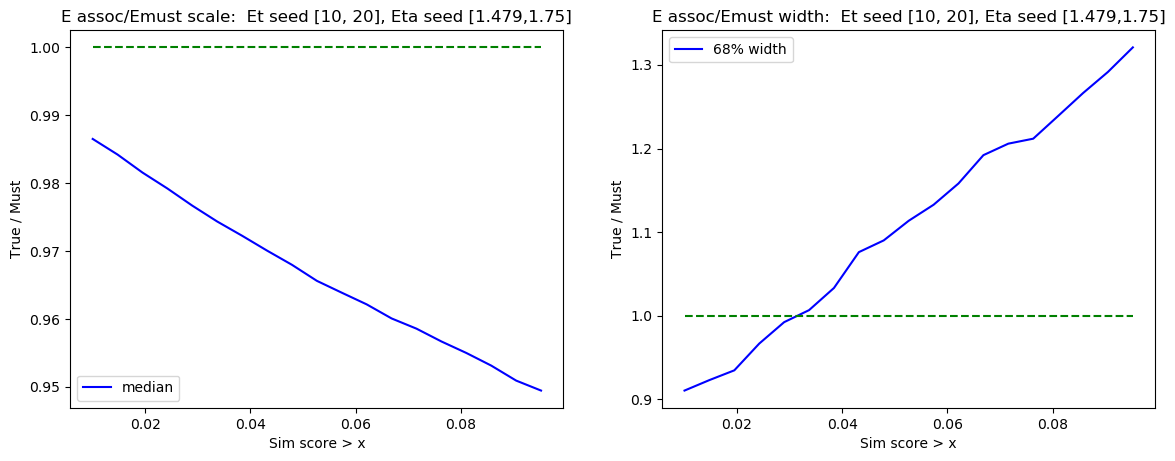

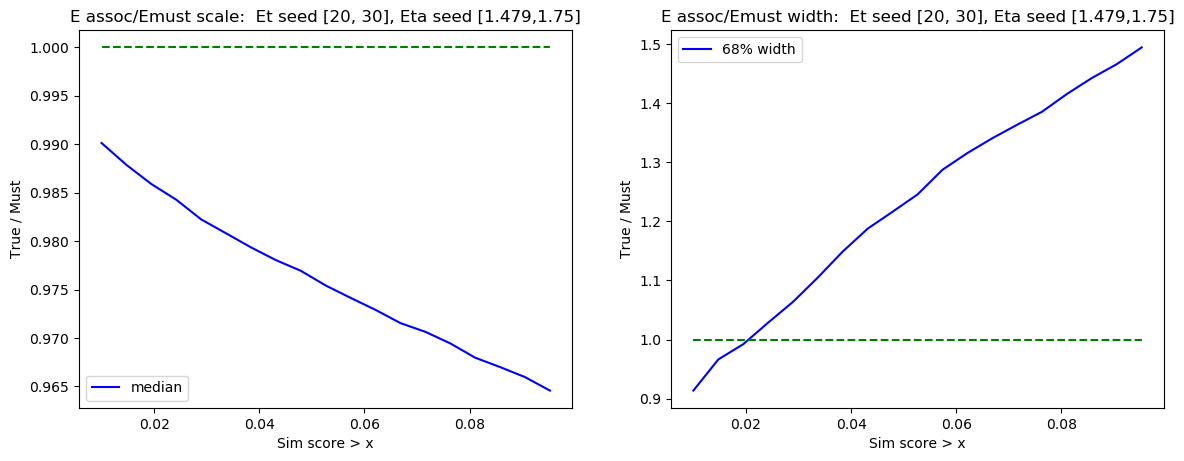

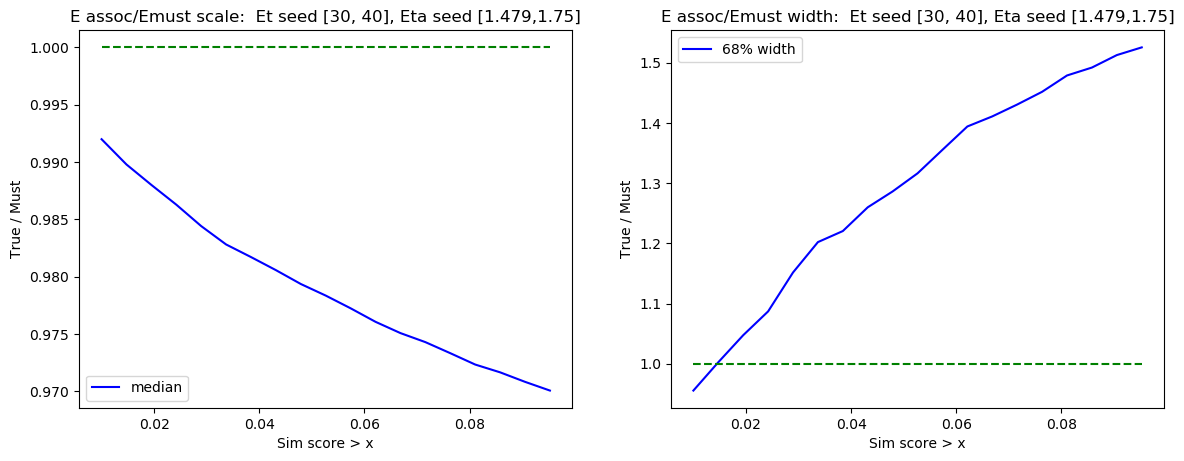

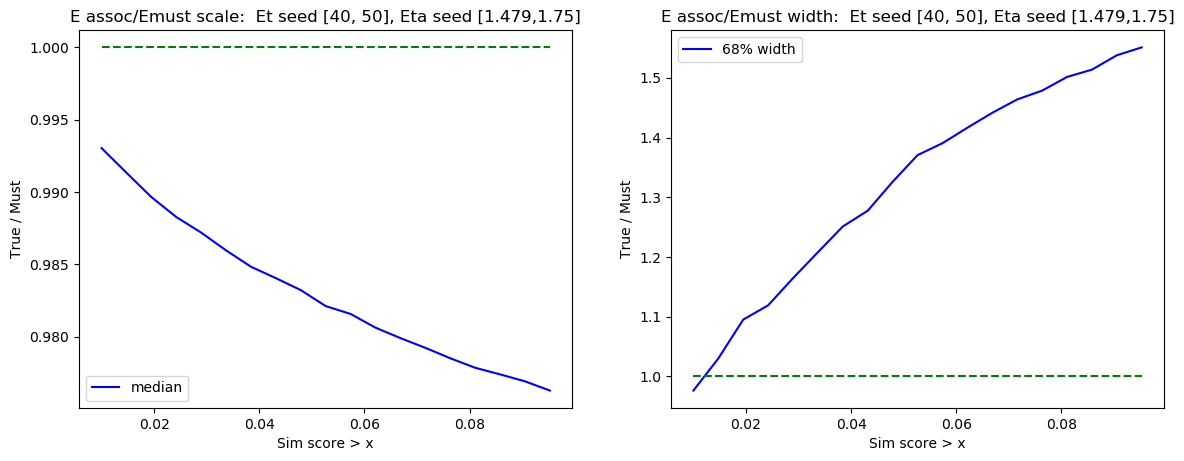

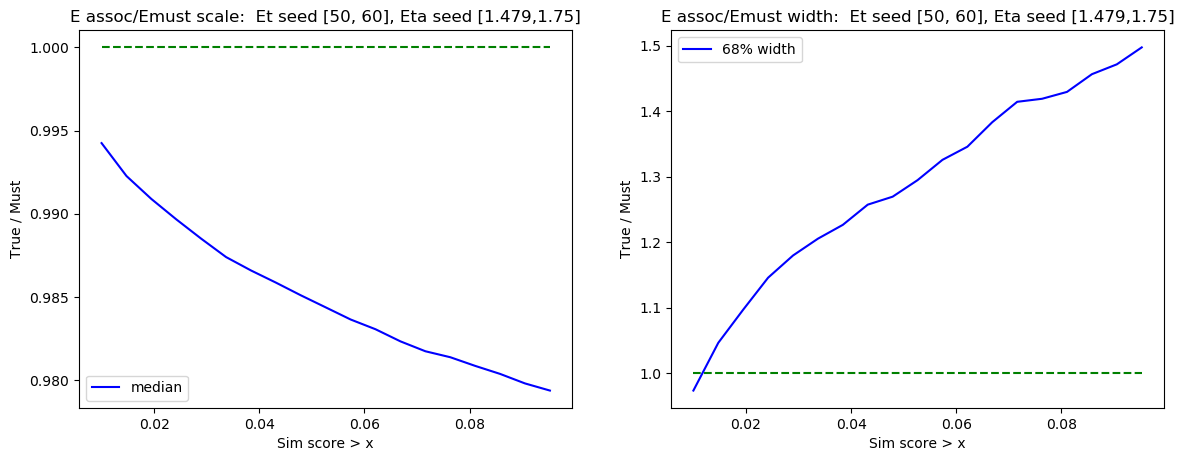

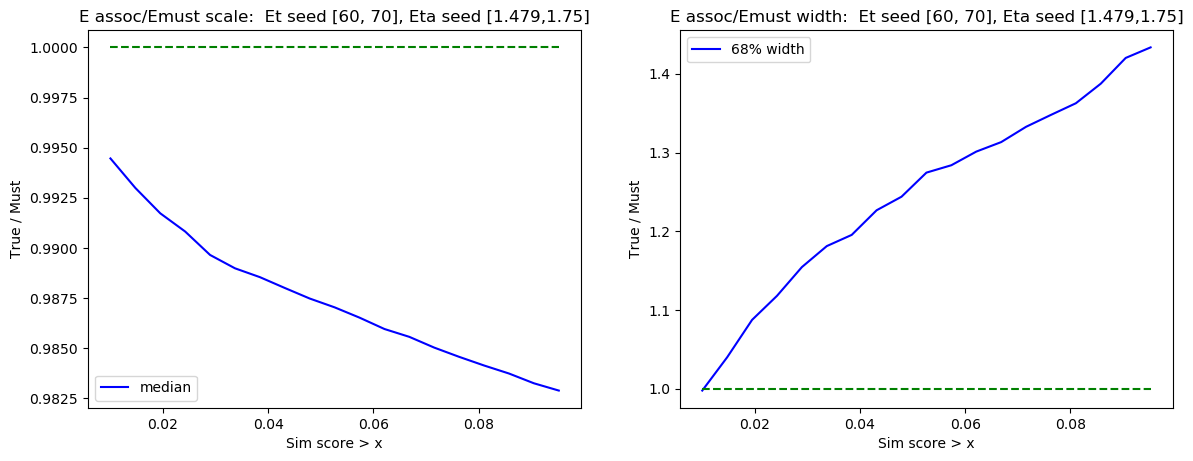

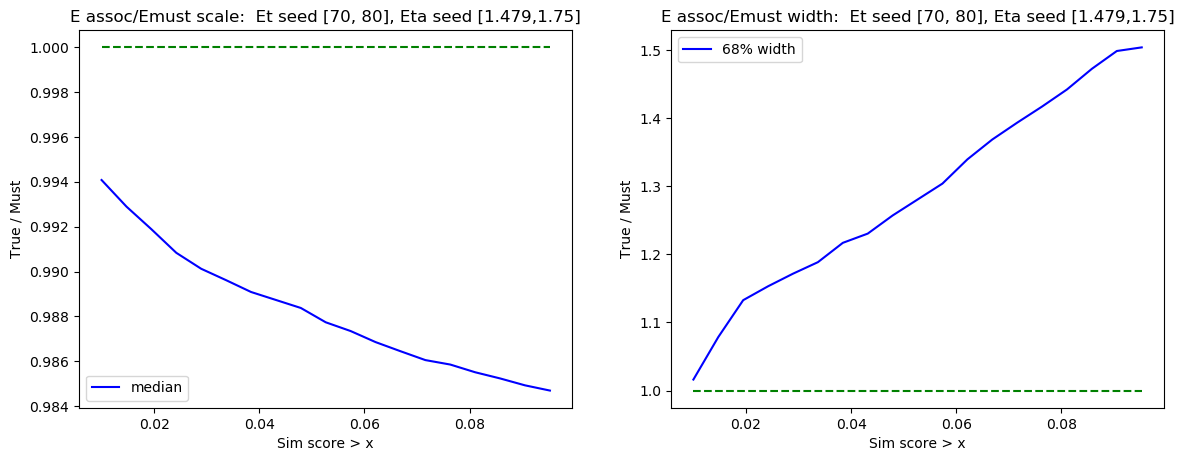

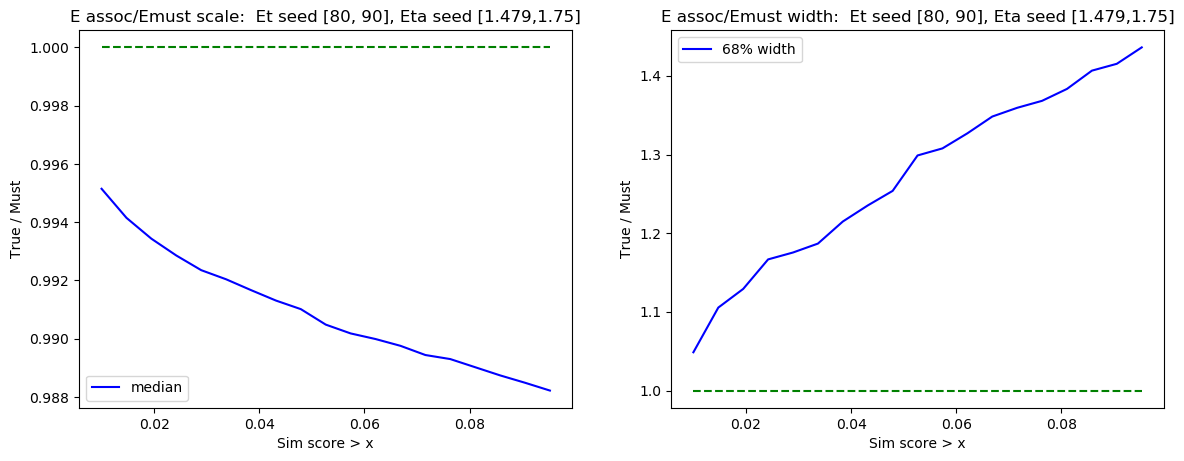

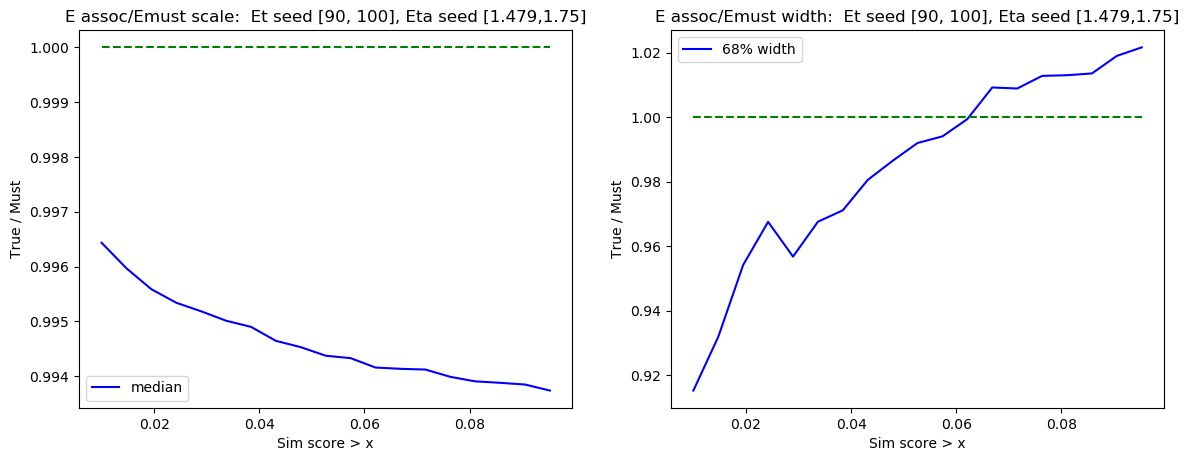

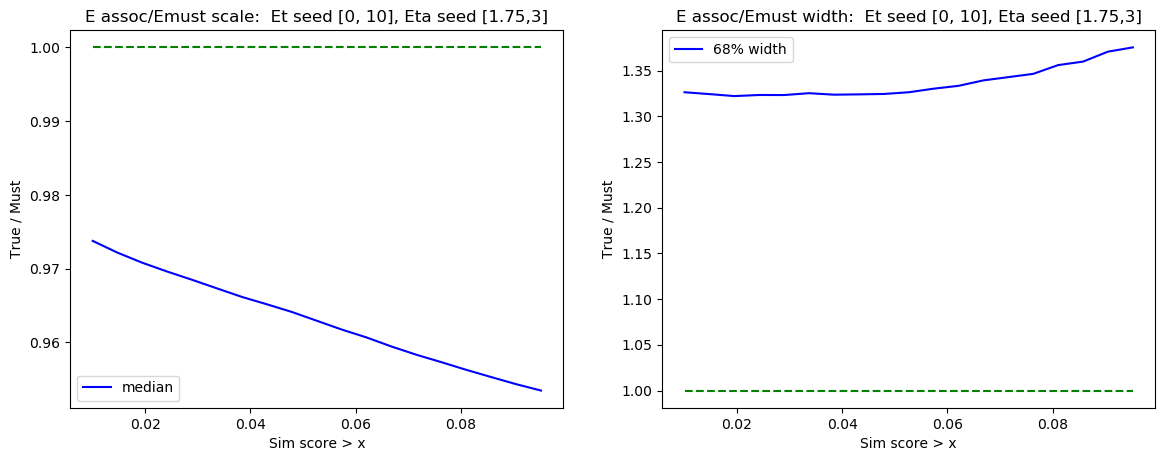

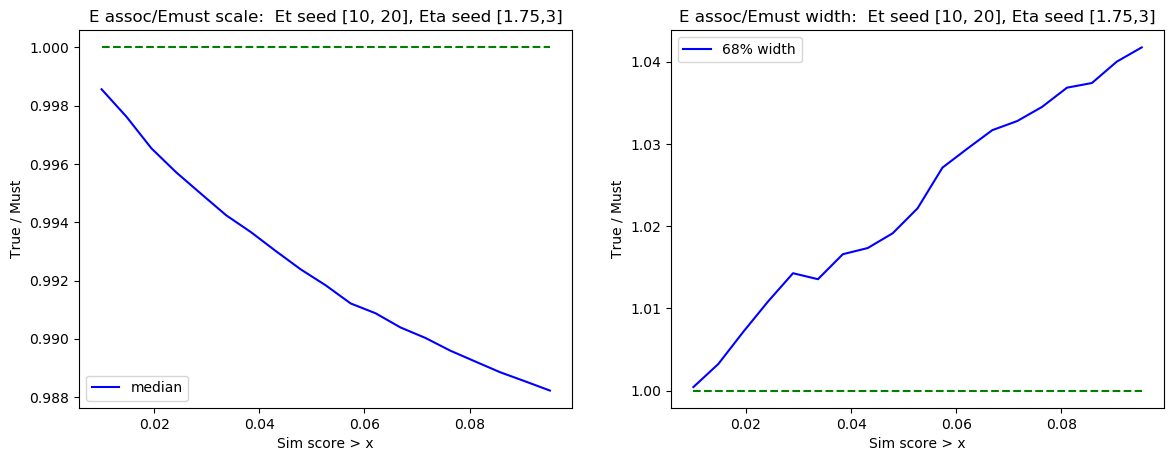

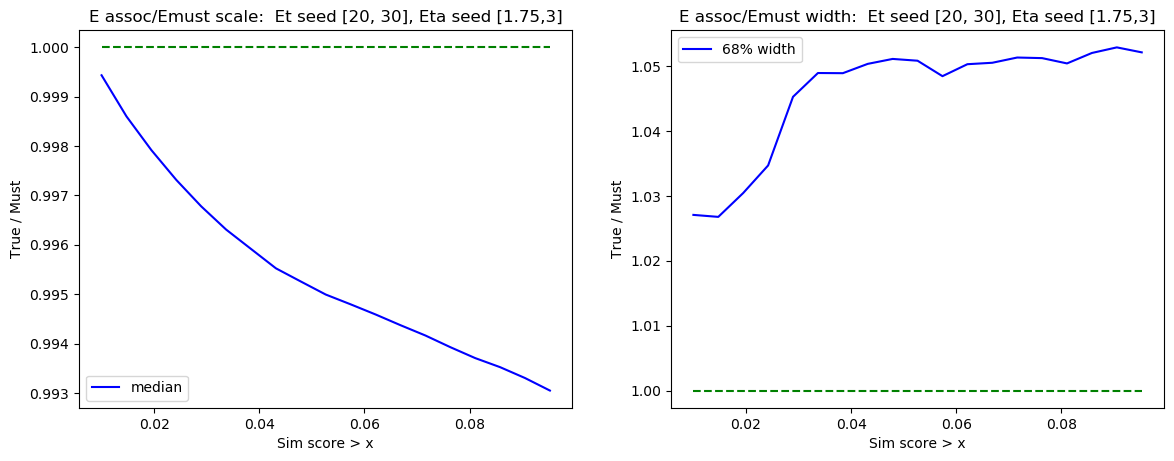

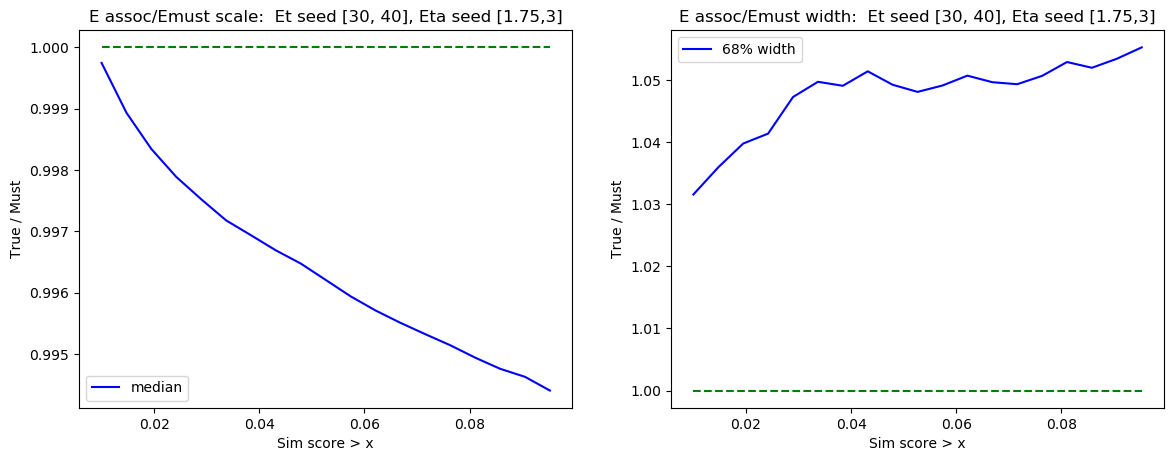

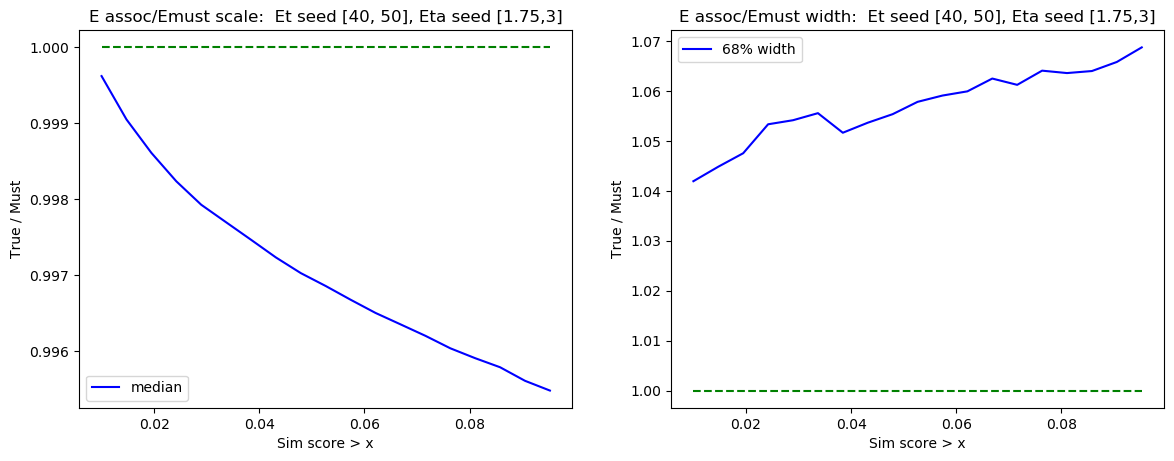

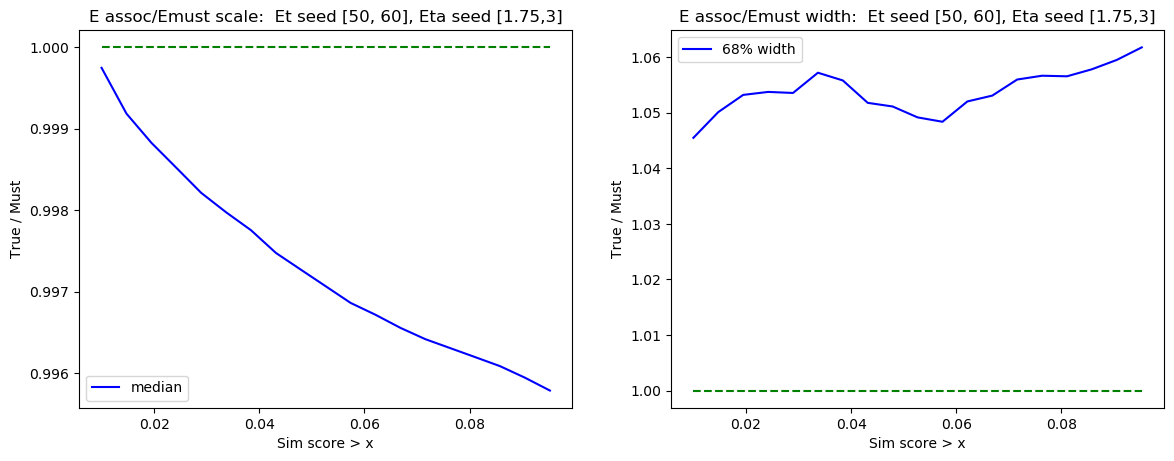

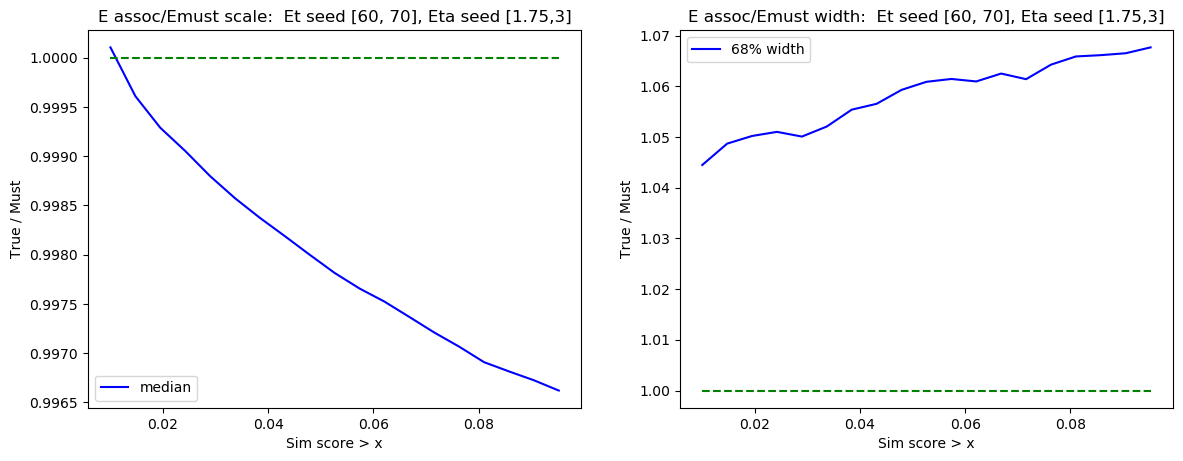

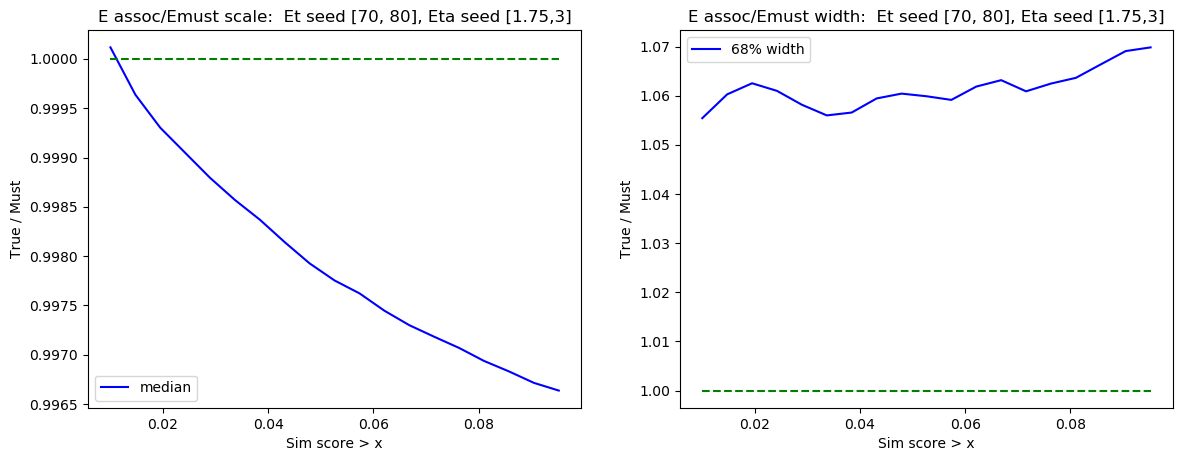

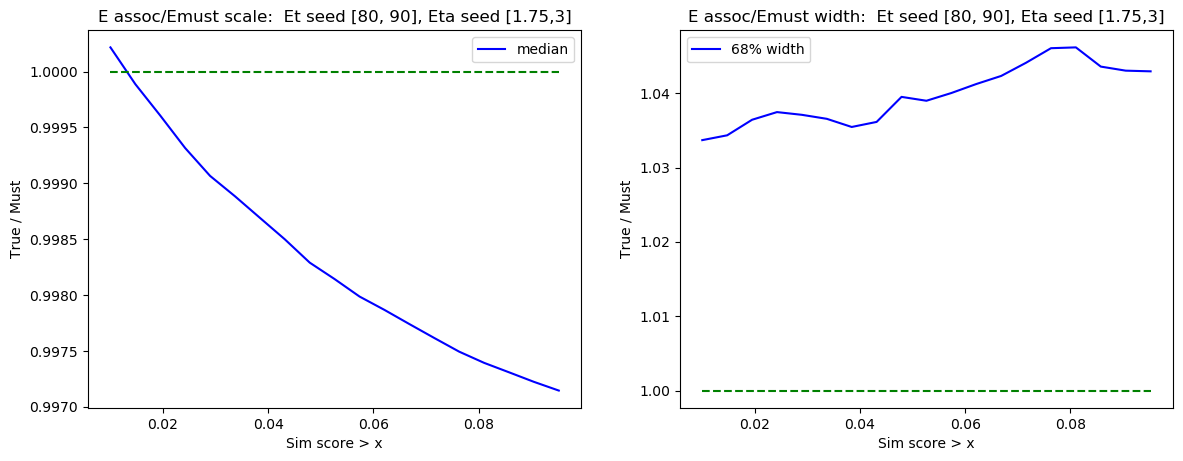

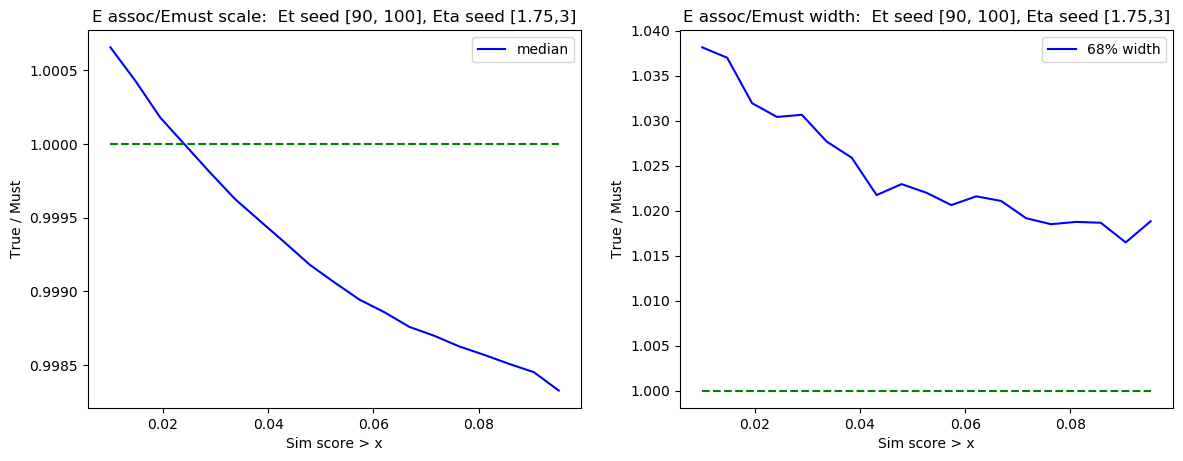

In [10]:
for eta_bin in range(len(etas)-1):
    
    for enbin in range(len(ens)-1):
        
        fig, [ax1,ax2] = plt.subplots(1,2, figsize=(14,5), dpi=100)
        
        df_true = result_true[(result_true.en_bin==enbin) & (result_true.eta_bin == eta_bin)]
        #df_mustmat = result_mustmatched[(result_mustmatched.en_bin==enbin)]
        x = df_true.simscore_thre.values
        
        # scale
        #y_mustmatched = df_mustmat["EoEtrue_68scale"].values
        y_must = result_must[(result_must.en_bin==enbin) & (result_must.eta_bin == eta_bin)]["EoEtrue_68scale"].iloc[0]
        y_true = df_true["EoEtrue_68scale"]

        ax1.plot(x, y_true/y_must, "b",label="median")
        #ax1.plot(x, y_mustmatched/y_must, "b",label="median - mustache seed matched")
        ax1.plot(x, [1.]*len(x), "g--")
        
        
        ax1.legend()
        ax1.set_xlabel("Sim score > x")
        ax1.set_ylabel("True / Must")
        ax1.set_title(f"E assoc/Emust scale:  Et seed [{ens[enbin]}, {ens[enbin+1]}], Eta seed [{etas[eta_bin]},{etas[eta_bin+1]}]")
        
        ##### width
        y_must = result_must[(result_must.en_bin==enbin) & (result_must.eta_bin == eta_bin)]["EoEtrue_68width"].iloc[0] 
        y_true = df_true["EoEtrue_68width"]
        # y_must_up = result_must[result_must.en_bin==enbin]["quantile_up"].iloc[0]
        # y_must_do = result_must[result_must.en_bin==enbin]["quantile_down"].iloc[0]
        
        ax2.plot(x, y_true/y_must,  "b", label="68% width",)
        # ax2.plot(x, y_calo_up/y_must_up,  "red", label="68% width - quantile up",)
        # ax2.plot(x, y_calo_do/y_must_do,  "orange", label="68% width - quantile down",)
        #ax2.plot(x, y_mustmatched/y_must,  "b", label="68% width - mustache seed matched",)
        ax2.plot(x, [1.]*len(x), "g--")
        
        ax2.legend()
        ax2.set_xlabel("Sim score > x")
        ax2.set_ylabel("True / Must")
        ax2.set_title(f"E assoc/Emust width:  Et seed [{ens[enbin]}, {ens[enbin+1]}], Eta seed [{etas[eta_bin]},{etas[eta_bin+1]}]")
        
        fig.savefig(outputdir +f"/scale_width_eta_{etas[eta_bin]}-{etas[eta_bin+1]}_et_{ens[enbin]}-{ens[enbin+1]}_seed.png")
        

